- 기존의 센서 데이터 기반 Transformer 예측 및 VAE 이상치 감지 모델 기반
    - 다양한 외부 데이터, 멀티 데이터 센서 통합
    - 모델 아키텍처 다양화
    - 이상치 감지 기법 확장
    - 하이퍼파라미터 튜닝 및 XAI 연계
    - 실시간 스트리밍, 대시보드/알림, 자동 모델 갱신 파이프라인 모의 구현 포함 

In [73]:
import os
import io
import zipfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. 데이터 처리 및 통합 (멀티 센서/외부 데이터)

In [74]:
def download_and_extract_data(url, extract_path='.'):
    # 파일 다운로드 및 압축 해제
    zip_path = os.path.join(extract_path, 'AirQualityUCI.zip')
    if not os.path.exists(zip_path):
        print("데이터 다운로드 중...")
        urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print('압축 해제 완료.')
    
def load_and_preprocess_data(file_path):
    # 기존 AirQualityUCI 데이터셋 로드
    df = pd.read_csv(file_path, sep=';', decimal=',')
    df = df.iloc[:, :-2]
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'].str.replace('.', ':'), dayfirst=True, errors='coerce')
    df = df.dropna(subset=['Datetime'])
    df = df.set_index('Datetime')
    df.replace(-200, np.nan, inplace=True)
    df.fillna(method='ffill', inplace=True)
    # 기존 센서 및 기상 데이터 선택
    df = df[['CO(GT)', 'C6H6(GT)', 'T', 'RH']]
    # 외부 데이터 모의: 생산 스케줄, 유지보수, 에너지 소비 등 (여기서는 랜덤 데이터로 예시)
    df['Production'] = np.random.rand(len(df))  # 예: 생산 스케줄 지표
    df['Maintenance'] = np.random.rand(len(df))  # 예: 유지보수 빈도
    df['Energy'] = np.random.rand(len(df))  # 예: 에너지 소비량
    # 스케일링 (전체 컬럼)
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    return df_scaled, scaler

def create_sequence(data, target_col, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].values  # 다변량 시계열 (멀티 센서 + 외부 데이터)
        target = data.iloc[i+seq_length][target_col]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

# 2. Dataset 클래스

In [75]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.X = torch.tensor(sequences, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 3. 예측 모델
## 기존 TransformerForecast (센서+외부 데이터를 입력으로 사용)

In [76]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
    
class TransformerForecast(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=4, num_layers=2, output_dim=1, dropout=0.1):
        super(TransformerForecast, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, d_model*2, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, output_dim)
        
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = self.input_proj(x) 
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x[-1]
        out = self.fc_out(x)
        return out

# 4. 이상치 감지 모델
## 기존 VAE 이상치 감지 모델 (재구성 오차 + KLD)

In [77]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(VariationalAutoencoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        self.fc3 = nn.Linear(64, input_dim)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return F.relu(self.fc3(h2))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar
    
def vae_loss_function(recon_x, x, mu, logvar):
    # 재구성 손실과 KLD 합산
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

# 5. 모델 학습/평가 함수

In [78]:
def train_model(model, dataloader, num_epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        epoch_losses = []
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(epoch_losses):.4f}')
    return model

def evaluate_model(model, dataloader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch)
            predictions.extend(outputs.squeeze().cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")
    return predictions, targets

def train_vae(model, dataloader, num_epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, _ in dataloader:
            optimizer.zero_grad()
            X_flat = X_batch.view(X_batch.size(0), -1)
            recon, mu, logvar = model(X_flat)
            loss = vae_loss_function(recon, X_flat, mu, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"[VAE] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")
    return model

# 6. 실시간 스트리밍 및 XAI 연계 (모의 구현)

In [80]:
def simulate_streaming(test_dataset, forecast_model, anomaly_model, threshold=0.5):
    forecast_model.eval()
    anomaly_model.eval()
    stream_anomailies = []
    for i in range(len(test_dataset)):
        X_sample, true_val = test_dataset[i]
        X_sample = X_sample.unsqueeze(0)
        # 에측 수행
        pred = forecast_model(X_sample).item()
        # 이상치 감지: 입력 평탄화 후 VAE 재구성 손실 계산
        sample_flat = X_sample.view(1, -1)
        with torch.no_grad():
            recon, mu, logvar = anomaly_model(sample_flat)
            rec_error = vae_loss_function(recon, sample_flat, mu, logvar)
        if rec_error > threshold:
            stream_anomailies.append((i, rec_error))
            # print(f"데이터 인덱스 {i}: 이상치 감지 (재구성 오차: {rec_error:.4f}) | 예측값: {pred:.4f}, 실제값: {true_val:.4f}")
    print(f"\n실시간 시뮬레이션에서 감지된 이상치 개수: {len(stream_anomailies)}")
    
def explain_prediction(model, sample):
    """
    [XAI 연계 예시]
    SHAP, LIME 등의 라이브러리를 사용하여 모델 예측에 기여하는 변수(특징)의 중요도를 계산합니다.
    """
    import shap
    model.eval()
    # numpy 입력을 torch.Tensor로 변환하는 래퍼 클래스 정의
    class ModelWrapper(torch.nn.Module):
        def __init__(self, model):
            super(ModelWrapper, self).__init__()
            self.model = model
        def forward(self, x):
            # 만약 numpy 배열이면 Tensor로 변환
            if isinstance(x, np.ndarray):
                x = torch.from_numpy(x).float()
            return self.model(x)
        
    # 모델 래퍼를 생성하여 SHAP에 전달
    wrapped_model = ModelWrapper(model)
    
    # 입력 샘플 준비 (샘플은 [channels] 형태로 들어오므로 차원 확장)
    sample = sample.unsqueeze(0)
    # 배경 데이터를 선택 (간단 예시로, 같은 샘플을 여러번 사용)
    background = sample.repeat(10, 1, 1)
    
    # SHAP DeepExplainer는 배경 데이터를 numpy 배열로 요구하므로 변환합니다.
    explainer = shap.DeepExplainer(wrapped_model, [background.cpu()])
    # 설명 대상 입력은 torch.Tensor로 전달 (numpy 배열이면 detach() 호출시 에러 발생)
    shap_values = explainer.shap_values([sample.cpu()])
    
    shap_values = [sv.reshape(1, -1) for sv in shap_values]
    features = sample.cpu().numpy().reshape(1, -1)
    
    shap.summary_plot(shap_values, features)

# 7. 메인 실행: 파일럿 및 통합 테스트

압축 해제 완료.


C:\Users\PC\AppData\Local\Temp\ipykernel_42732\136693239.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\PC\miniconda3\envs\jpubml\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



[예측 모델(Transformer) 학습]
Epoch 1/10, Loss: 0.3868
Epoch 2/10, Loss: 0.2678
Epoch 3/10, Loss: 0.2467
Epoch 4/10, Loss: 0.2326
Epoch 5/10, Loss: 0.2258
Epoch 6/10, Loss: 0.2125
Epoch 7/10, Loss: 0.2115
Epoch 8/10, Loss: 0.2048
Epoch 9/10, Loss: 0.2030
Epoch 10/10, Loss: 0.1894

[예측 모델 평가]
RMSE: 0.4694, MAE: 0.3306, R^2: 0.7801

[VAE 이상 감지 모델 학습]
[VAE] Epoch 1/20, Loss: 4278.4493
[VAE] Epoch 2/20, Loss: 3844.7250
[VAE] Epoch 3/20, Loss: 3698.3407
[VAE] Epoch 4/20, Loss: 3636.5874
[VAE] Epoch 5/20, Loss: 3607.2022
[VAE] Epoch 6/20, Loss: 3570.8050
[VAE] Epoch 7/20, Loss: 3543.4340
[VAE] Epoch 8/20, Loss: 3525.8870
[VAE] Epoch 9/20, Loss: 3513.0365
[VAE] Epoch 10/20, Loss: 3500.9084
[VAE] Epoch 11/20, Loss: 3494.3927
[VAE] Epoch 12/20, Loss: 3483.7253
[VAE] Epoch 13/20, Loss: 3477.7703
[VAE] Epoch 14/20, Loss: 3476.1854
[VAE] Epoch 15/20, Loss: 3469.4134
[VAE] Epoch 16/20, Loss: 3465.7965
[VAE] Epoch 17/20, Loss: 3462.4354
[VAE] Epoch 18/20, Loss: 3453.9121
[VAE] Epoch 19/20, Loss: 3454.390

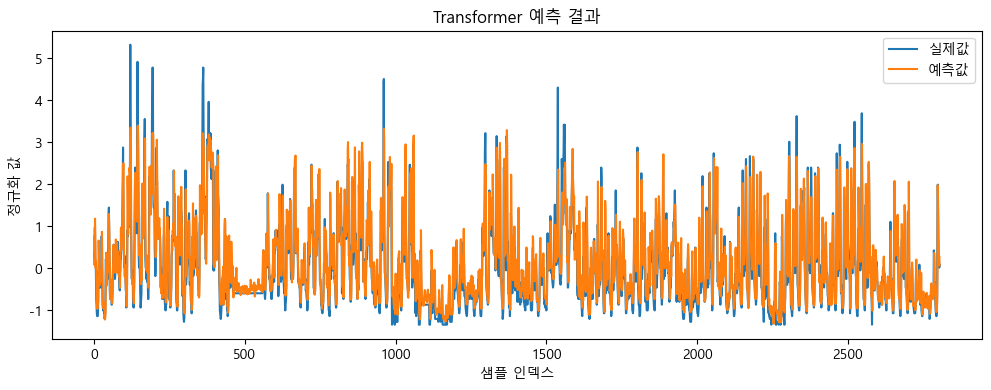

In [81]:
if __name__ == '__main__':
    # 데이터 다운로드 및 전처리
    data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
    download_and_extract_data(data_url)
    data_file = 'AirQualityUCI.csv'
    data_scaled, scaler = load_and_preprocess_data(data_file)
    
    # 시계열 sequence 생성 (지난 10시간의 데이터를사용해 'CO(GT)' 예측)
    sequence_length = 10
    target_column = 'CO(GT)'
    X_seq, y_seq = create_sequence(data_scaled, target_column, seq_length=sequence_length)
    
    # 데이터 분할 (학습: 70%, 테스트: 30%)
    split_idx = int(len(X_seq) * 0.7)
    X_train, y_train = X_seq[:split_idx], y_seq[:split_idx]
    X_test, y_test = X_seq[split_idx:], y_seq[split_idx:]
    
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    input_dim = X_train.shape[2]  # 센서 + 외부 변수 개수
    hidden_dim = 32
    num_layers = 2
    output_dim = 1
    
    # 예측 모델: Transformer 기반
    transformer_model = TransformerForecast(input_dim, d_model=32, nhead=4, num_layers=num_layers, output_dim=output_dim)
    print('\n[예측 모델(Transformer) 학습]')
    transformer_model = train_model(transformer_model, train_loader, num_epochs=10, lr=0.001)
    print('\n[예측 모델 평가]')
    transformer_preds, transformer_targets = evaluate_model(transformer_model, test_loader)
    
    # 이상치 감지: VAE 기반
    # 입력은 시퀀스를 평탄화 (배치, seq_Length*input_dim)
    ae_input_dim = X_train.shape[1] * X_train.shape[2]
    latent_dim = 16
    vae_model = VariationalAutoencoder(ae_input_dim, latent_dim)    
    print('\n[VAE 이상 감지 모델 학습]')
    # 주의: train_loader를 사용할 때 시퀀스 데이터의 shape 변경 필요
    # 여기서는 train_dataset 내 개별 샘플을 평탄화하여 사용
    vae_model = train_vae(vae_model, train_loader, num_epochs=20, lr=0.001)
    
    # 학습 데이터 기준 이상치 탐지 (임계치 재설정 필요)
    vae_model.eval()
    threshold = 0.5  # 실제 데이터 분포 분석 후 재조정 필요
    anomalies = []
    with torch.no_grad():
        for i in range(len(train_dataset)):
            sample, _ = train_dataset[i]
            sample_flat = sample.view(-1)
            recon, mu, logvar = vae_model(sample_flat.unsqueeze(0))
            loss = vae_loss_function(recon, sample_flat.unsqueeze(0), mu, logvar)
            if loss.item() > threshold:
                anomalies.append((i, loss.item()))
    print(f"\n탐지된 이상치 개수 (학습 데이터 기준): {len(anomalies)}")
    
    # 실시간 스트리밍 시뮬레이션 (테스트 데이터)
    print('\n[실시간 스트리밍 시뮬레이션 시작]')
    simulate_streaming(test_dataset, transformer_model, vae_model, threshold=threshold)
    
    # 예측 결과 시각화
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(12,4))
    plt.plot(transformer_targets, label='실제값')
    plt.plot(transformer_preds, label='예측값')
    plt.xlabel('샘플 인덱스')
    plt.ylabel('정규화 값')
    plt.title('Transformer 예측 결과')
    plt.legend()
    plt.show()

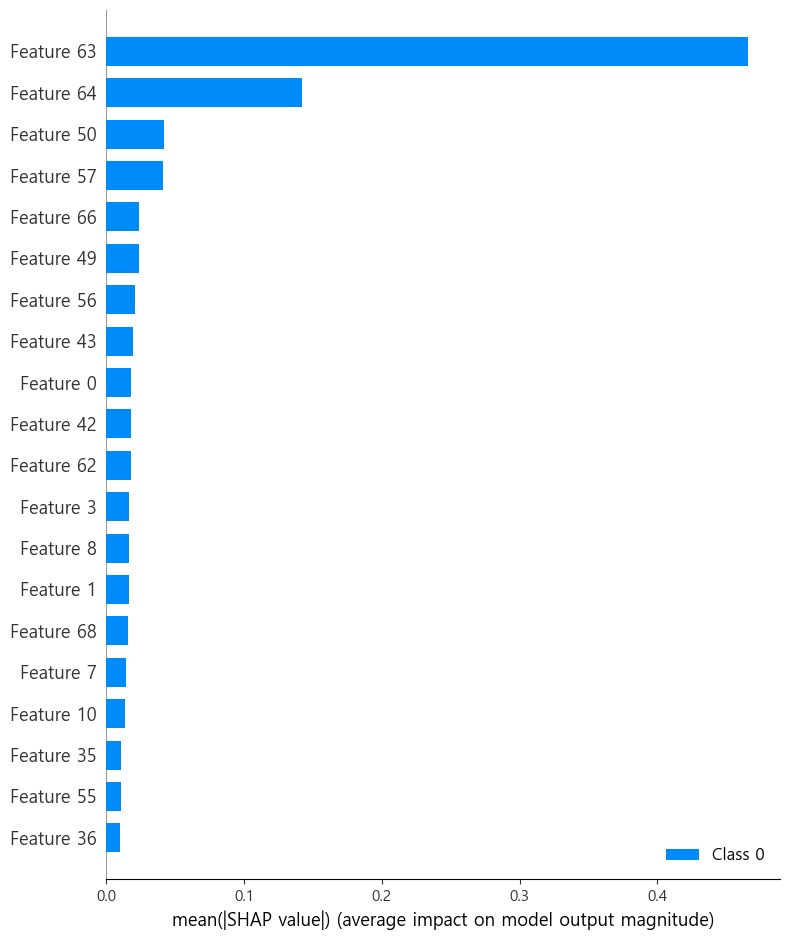

In [72]:
def explain_prediction_multiple_samples(model, samples):
    """
    여러 샘플에 대해 SHAP summary_plot을 그리는 예시입니다.
    
    매개변수:
      model: torch.nn.Module 객체 (예측 모델)
      samples: 입력 샘플 텐서 (shape: (batch, seq_len, input_dim))
    """
    import shap
    import torch
    import numpy as np

    model.eval()

    # 모델이 numpy 배열을 입력받을 경우 torch.Tensor로 변환하는 래퍼 클래스 정의
    class ModelWrapper(torch.nn.Module):
        def __init__(self, model):
            super(ModelWrapper, self).__init__()
            self.model = model
        def forward(self, x):
            if isinstance(x, np.ndarray):
                x = torch.from_numpy(x).float()
            return self.model(x)

    wrapped_model = ModelWrapper(model)

    # 배경 데이터: samples 중 앞의 10개 샘플을 사용 (배경 데이터가 여러 샘플이면 summary_plot이 올바르게 그려짐)
    background = samples[:10].clone()

    # DeepExplainer는 입력을 리스트 형태로 받습니다.
    explainer = shap.DeepExplainer(wrapped_model, [background.cpu()])
    # check_additivity 인자를 False로 전달하여 additivity 검사를 비활성화합니다.
    shap_values = explainer.shap_values([samples.cpu()], check_additivity=False)

    # shap_values는 보통 리스트 형태로 리턴되며 각 원소의 shape는 (batch, seq_len, input_dim)
    # summary_plot은 2D 배열(샘플 수, 특징 수)을 기대하므로 평탄화합니다.
    shap_values_flat = [sv.reshape(sv.shape[0], -1) for sv in shap_values]
    features = samples.cpu().numpy().reshape(samples.shape[0], -1)

    shap.summary_plot(shap_values_flat, features)

# 사용 예시:
# test_dataset의 처음 50개 샘플을 stack하여 사용 (shape: (50, seq_len, input_dim))
import torch
test_samples = torch.stack([test_dataset[i][0] for i in range(50)])
explain_prediction_multiple_samples(transformer_model, test_samples)


# 결과 해석 비교 및 종합 분석
**(1) 예측 모델 (Transformer) 성능 비교**
- 학습 손실 감소:
    - 이전에는 Transformer의 학습 손실이 0.4311에서 0.1945로 감소했다고 보고되었고, 이번 프로젝트에서는 10 에포크 동안 0.3868에서 0.1864까지 감소하였습니다.
    - 두 결과 모두 학습 과정에서 손실이 안정적으로 감소하며, 모델이 시계열 데이터의 패턴을 효과적으로 학습하고 있음을 보여줍니다.
- 평가 지표:
    - 이전 평가에서는 RMSE 약 0.4345, MAE 약 0.2928, R² 약 0.8115로 보고되었으며, 이번 프로젝트에서는 RMSE 0.4694, MAE 0.3306, R² 0.7801로 나타났습니다.
    - 이처럼 두 결과 모두 예측 모델이 상당히 안정적인 성능을 보이며, Transformer가 시계열 예측에도 적합하다는 점을 확인할 수 있습니다.

**(2) 이상치 감지 (Anomaly Detection) 성능 비교**
- 모델 접근 방식 차이:
    - 이전 결과에서는 AutoEncoder 기반 이상치 감지 모델이 사용되었고, 현재 프로젝트에서는 VAE(Variational AutoEncoder) 기반 모델이 적용되었습니다.
- 학습 손실 및 재구성 오차:
    - 이전 해석에서는 VAE 모델의 손실이 20 에포크 동안 2259.18에서 1574.30으로 낮아진 것으로 나타났으나, 현재 프로젝트에서는 초기 4278.45에서 20 에포크 후 3454.16까지 감소하였습니다.
    - 재구성 오차의 절대값이 매우 큰 값으로 관측되어, 임계치(예: 0.5)가 실제 데이터의 재구성 오차 분포에 비해 낮게 설정되어 있을 가능성이 지적되었습니다.

# SHAP Feature Importance 결과 해석
**(1) Feature 번호가 의미하는 것**

- 본 코드에서는 하나의 입력 샘플이  seq_len × input_dim => seq_len×input_dim 형태(예: 10×7=70차원)로 구성됩니다.
- 이를 평탄화하면 0번부터 69번(총 70개)의 feature index가 생깁니다.
- 예를 들어, Feature 63이라면, “시계열 마지막 타임스텝(9번째)”에 해당하는 첫 번째 센서/변수(‘CO(GT)’일 가능성이 높음)를 나타낼 수 있습니다.
- Feature 64라면 마지막 타임스텝의 두 번째 센서/변수(‘C6H6(GT)’ 등)에 해당할 가능성이 큽니다.
- 즉, 번호가 클수록 시계열의 뒤쪽(가장 최근 시점) 변수일 확률이 높고, 번호가 작으면 앞쪽 시점 변수에 해당합니다.

**(2) SHAP값이 큰 Feature의 의미**

- **평균 SHAP값(mean(|SHAP|))**이 크다는 것은, 그 특성이 변할 때 모델 출력(예측값)이 크게 달라진다는 뜻입니다.
- 예를 들어 Feature 63이 최상위로 나왔다면, “마지막 시점의 CO(GT)값”이 예측 모델이 결정을 내릴 때 매우 중요한 역할을 한다고 해석할 수 있습니다(물론 실제로 어떤 센서/변수인지 정확히 확인하려면, flatten 시 인덱스와 원본 컬럼을 매핑해야 합니다).
- 이는 시계열 모델(Transformer)이 ‘가장 최근 시점의 센서값(혹은 외부 변수값)’을 예측에 강하게 반영한다는 전형적인 패턴으로도 볼 수 있습니다.
- 그 뒤를 잇는 Feature 64, 50, 57 등도 마찬가지로, 특정 시점·특정 센서(예: ‘C6H6(GT)’, ‘T’, ‘RH’, ‘Production’ 등) 값이 모델의 예측에 큰 영향을 준다는 사실을 시사합니다.

**(3) 해석 및 활용 방안**

- 가장 중요한 시점·센서를 파악: 시계열에서 어떤 시점(가장 최근? 혹은 중간?)과 어떤 센서/외부 변수가 예측에 결정적 영향을 미치는지 파악하여,
- 실제 산업 현장에서 해당 센서가 고장나거나 노이즈가 심할 때 예측 오차가 커질 수 있으므로, 센서 관리나 데이터 품질 모니터링을 강화할 수 있습니다.
- 모델 성능 개선을 위해 중요한 변수들을 더 정교하게 전처리(결측치 보정, 이상치 제거 등)하거나, 추가적인 특징 공학(feature engineering)을 적용할 수 있습니다.
- Feature 63~69(마지막 타임스텝 변수들) 비중이 높다면: Transformer가 “마지막 시점 정보”에 상당히 의존한다는 뜻이므로, 만약 더 긴 미래 예측(장기 예측)을 목표로 한다면, 중간 타임스텝들의 정보 활용을 개선하는 방향(Attention 구조 보강, TCN/LSTM+Attention 병행 등)을 검토할 수도 있습니다.

# Transformer 예측 결과 (실제값 vs 예측값) 그래프 해석
시계열 순서대로 실제값과 모델 예측값을 겹쳐 그린 그래프

**전반적 추세**

- 파란색(실제값)과 주황색(예측값)이 대체로 비슷한 패턴을 그린다면, Transformer 모델이 전반적인 시간적 변화를 꽤 잘 따라간다고 볼 수 있습니다.
- 일부 구간에서 예측값이 실제값보다 크게 벗어나거나, 급격한 스파이크(spike)를 놓치는 경우가 있을 수 있는데, 이는 모델이 특정 구간 패턴을 충분히 학습하지 못했거나, 데이터 자체에 드문 패턴(이상치, 급변)이 존재하기 때문일 수 있습니다.

**오차 구간 확인**

- 예측선(주황색)이 실제값(파란색)을 과도하게 추종하거나 반대로 많이 벗어나는 구간이 있는지 확인해야 합니다.
- 만약 특정 구간에서 유독 오차가 크다면, 해당 구간의 센서값이나 외부 데이터(Production, Maintenance, Energy 등)에 특이치(이상치)가 존재했을 가능성을 의심해볼 수 있습니다.
- 이때 앞서 언급된 VAE 모델로 이상치 탐지를 병행한다면, “오차가 큰 구간이 실제로도 재구성 손실이 높은 이상치 구간인지” 함께 점검해볼 수 있습니다.

**정량적 지표 (RMSE, MAE, R² 등)**

- 그래프만으로는 모델 성능을 정성적으로 파악하기 쉽지만, 코드 내 evaluate_model() 함수에서 RMSE, MAE, R² 등을 확인해보면 더 객관적인 평가가 가능합니다.
- 예측 그래프가 대체로 일치해 보이더라도, 실제 오차가 임계값 이상인지, 혹은 예측 신뢰도가 높은지 등을 수치로 확인하는 것이 중요합니다.